# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from collections import defaultdict

In [2]:
%matplotlib inline

# Read model predictions

In [3]:
path = "running/transformer_hier++/"

In [4]:
df = pd.read_csv(os.path.join(path, "error_greedy_test.tsv"), delimiter="\t")
df_stats = pd.read_csv(os.path.join(path, "stats_greedy_test.tsv"), delimiter="\t")

In [5]:
df.head()

,file,context,gold,generated,loss,bleu,f1_entity
0,MUL1493,"SOS hello , i am trying to find a train that l...",SOS the closest arrival time i can give you is...,"SOS yes , i have [value_count] trains that wil...",9.049051,0.375771,0.000000
1,PMUL2380,"SOS hi , could you help me with some informati...",SOS absolutely ! what attraction were you thin...,SOS what about [attraction_name] ? EOS,6.287688,0.009921,0.000000
2,PMUL0205,SOS i need a place to stay in the [hotel_area]...,SOS of course ! we have multiple place -s to c...,SOS there are [value_count] guesthouses that m...,9.763255,0.007767,99.850125
3,PMUL1788,SOS please help me find a hotel called flinche...,SOS it s phone number is [hotel_phone] and is ...,"SOS yes , it s a hotel and the phone number is...",6.795474,20.149429,66.577830
4,PMUL1435,SOS i need to take a train from [train_departu...,SOS i have [value_count] that leave after [tra...,SOS there are [value_count] trains that leave ...,6.805921,23.080884,99.850125


In [6]:
df.describe()

,loss,bleu,f1_entity
count,7372.000000,7372.000000,7372.000000
mean,7.565840,20.449129,51.451595
std,2.382533,22.715048,46.284015
min,0.037561,0.000047,0.000000
25%,6.716732,0.019109,0.000000
50%,8.107281,16.505976,66.577830
75%,9.134729,33.649334,99.850125
max,13.191915,96.821333,99.935741


# Correlation b/w Metrics

## [DEFINE] Context Length + Bleu bins

In [7]:
df['context_length'] = df.apply(lambda r: len(r['context'].split('<br>')), 1)

In [8]:
df['bleu_bin'] = df.apply(lambda r: r['bleu']//10, 1)

In [9]:
df.sample(10)

,file,context,gold,generated,loss,bleu,f1_entity,context_length,bleu_bin
3169,PMUL3247,SOS can you get me information on a hotel call...,"SOS sure , what is your arrival information ? EOS",SOS what is your destination ? EOS,8.611607,0.666285,0.000000,7,0.0
2260,MUL0528,SOS i am looking for a place called [attractio...,SOS there are [value_count] trains that leave ...,SOS there are [value_count] trains that leave ...,5.461337,25.771318,99.850125,5,2.0
2068,MUL0527,"SOS hi , could you tell me some attractions in...","SOS i am , sorry , but the entrance fee is not...","SOS i am sorry , but i do not have that inform...",7.542342,0.344199,0.000000,5,0.0
950,PMUL0509,SOS i am looking for a train to [train_destina...,SOS what date and time would you like to depar...,SOS what day and time would you like to travel...,1.073290,47.037106,0.000000,1,4.0
7348,MUL2177,SOS i am looking for a place in [value_place] ...,SOS [train_trainid] arrives at [train_arriveby...,SOS [train_trainid] arrives by [train_arriveby...,3.007937,30.263014,99.850125,25,3.0
2191,MUL0034,SOS i am looking for an [restaurant_pricerange...,SOS the reference number is [restaurant_refere...,SOS your reference number is [restaurant_refer...,4.013971,51.013659,99.850125,5,5.0
6365,PMUL0938,SOS i want a place to dine in the [restaurant_...,"SOS booking was successful , the total fee is ...","SOS booking was successful , the total fee is ...",2.953863,68.655454,99.900050,15,6.0
818,MUL2122,SOS hello ! i am looking for train schedules f...,SOS sure ! there are several trains leaving fr...,SOS there are [value_count] trains leaving [tr...,9.195909,16.054814,0.000000,1,1.0
2583,PMUL3803,"SOS hello , i need a train to [train_destinati...","SOS i am sorry , that is the closest arrival t...","SOS yes , it is [value_count] . EOS",7.354735,0.000066,0.000000,5,0.0
7159,MUL1342,"SOS hi , i am trying to find a [restaurant_pri...","SOS alright , i have a [taxi_type] to pick you...",SOS i have booked you a [taxi_type] and the co...,8.926969,18.723850,66.600033,19,1.0


In [10]:
df.iloc[2099]['generated']

'SOS what time would you like to leave ? EOS'

In [11]:
df.iloc[2099]['gold']

'SOS where you will be traveling from and when would you like to leave ? EOS'

## Bleu vs. Context Length/turns

Observing slight decrease in bleu with context length.
 - Would be interesting to compare high context length performance across models
 - Check how many samples are availble for training for different context length

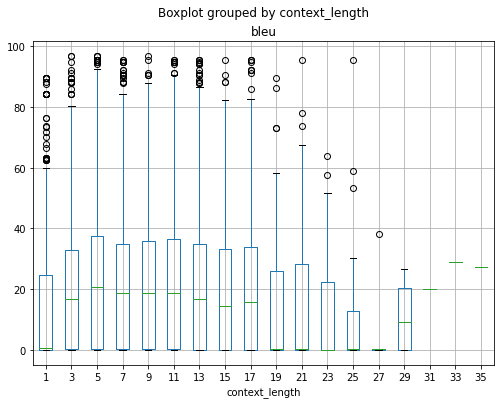

In [12]:
df.boxplot(column='bleu', by='context_length', figsize=(8,6))

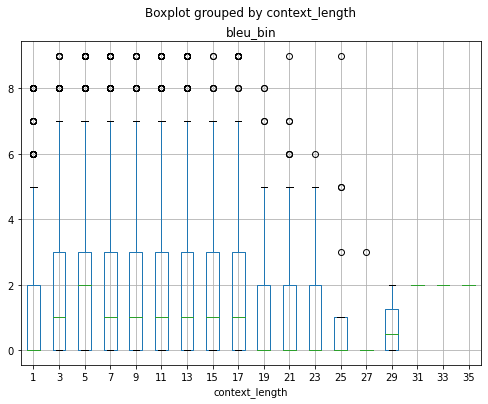

In [13]:
df.boxplot(column='bleu_bin', by='context_length', figsize=(8,6))

## [DEFINE] num_entities

In [14]:
regex_entity = r'\[([a-z\_\-]+)\]'

In [15]:
df['gold_entities'] = df.apply(lambda r: re.findall(regex_entity, r['gold']), 1)
df['num_entities'] = df.apply(lambda r: len(r['gold_entities']), 1)

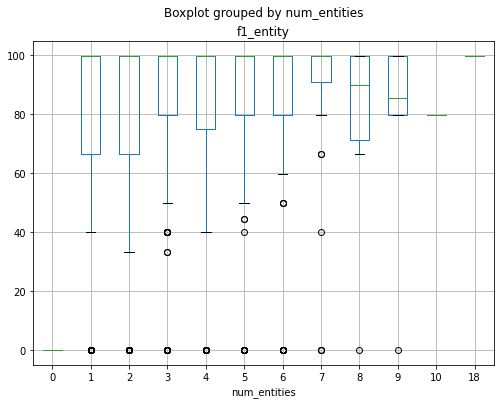

In [16]:
df.boxplot(column='f1_entity', by='num_entities', figsize=(8,6))

## [EXP] Scatter all pairs

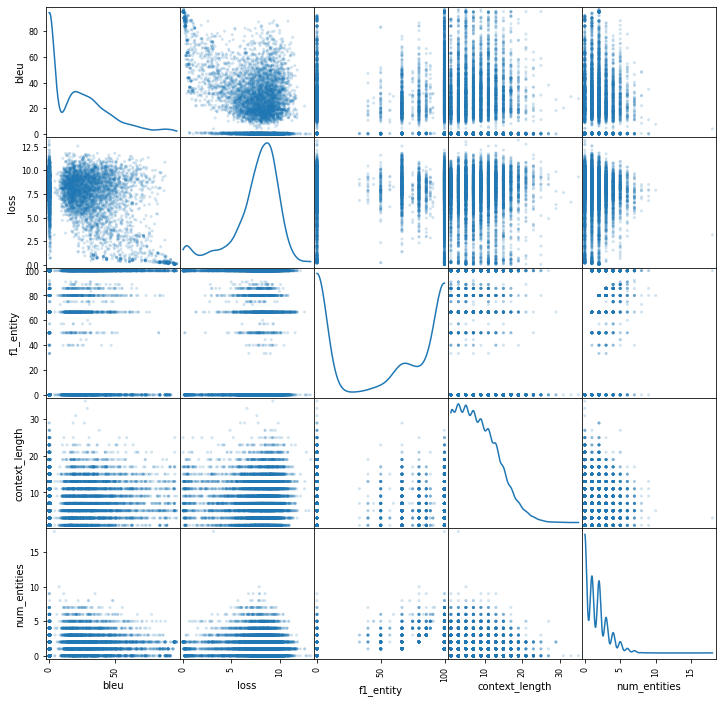

In [17]:
_ = scatter_matrix(df[['bleu', 'loss', 'f1_entity', 'context_length', 'num_entities']], alpha=0.2, diagonal='kde', figsize=(12,12))

## [EXP] Entitywise Avg. f1-entity

In [18]:
entity_log = {
    'entity':[],
    'loss':[],
    'bleu':[],
    'f1_entity':[],
    'context_length':[]
}
for _, row in df.iterrows():
    for e in row['gold_entities']:
        entity_log['entity'].append(e)
        entity_log['loss'].append(row['loss'])
        entity_log['bleu'].append(row['bleu'])
        entity_log['f1_entity'].append(row['f1_entity'])
        entity_log['context_length'].append(row['context_length'])

In [19]:
df_entity_log = pd.DataFrame.from_dict(entity_log)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 <a list of 38 Text major ticklabel objects>)

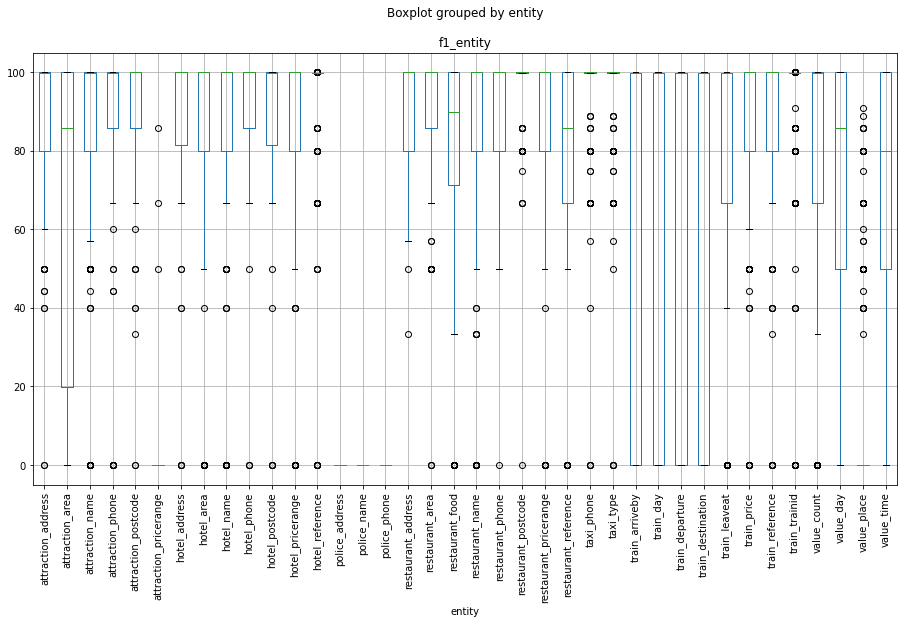

In [20]:
df_entity_log.boxplot(column='f1_entity', by='entity', figsize=(15,8))
plt.xticks(rotation=90)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 <a list of 38 Text major ticklabel objects>)

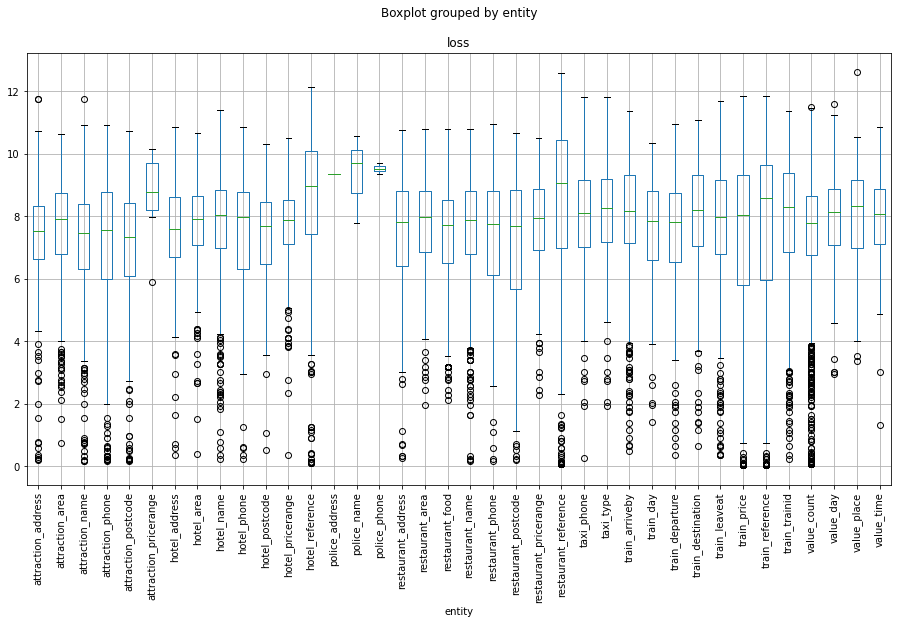

In [21]:
df_entity_log.boxplot(column='loss', by='entity', figsize=(15,8))
plt.xticks(rotation=90)

## [DEFINE] pred_entities

In [22]:
df['pred_entities'] = df.apply(lambda r: re.findall(regex_entity, r['generated']), 1)
df['num_pred_entities'] = df.apply(lambda r: len(r['pred_entities']), 1)

In [83]:
df.sample(4)

,file,context,gold,generated,loss,bleu,f1_entity,context_length,bleu_bin,gold_entities,num_entities,pred_entities,num_pred_entities,entity_prec,entity_recall,entity_f1
7088,MUL1066,SOS can you help me book a reservation at the ...,SOS [attraction_name] is considered an archite...,SOS [attraction_name] is a museum . would you ...,7.489381,0.451950,99.850125,19,0.0,[attraction_name],1,[attraction_name],1,1.0,1.0,1.0
6240,PMUL4025,SOS please see what you can find out about [at...,SOS thank you for using our service today ! EOS,SOS thank you for using our service . have a g...,2.632201,41.374422,0.000000,13,4.0,[],0,[],0,0.0,0.0,0.0
5388,PMUL3663,"SOS hello , i need a train to [train_destinati...",SOS it was a pleasure to help . have a good da...,SOS thank you for using our service . have a g...,5.097879,0.529415,0.000000,11,0.0,[],0,[],0,0.0,0.0,0.0
3094,SNG1026,SOS can you help me find a [hotel_pricerange] ...,SOS the [hotel_name] is located at [hotel_addr...,SOS the address for [hotel_name] is [hotel_add...,7.552344,0.017544,99.900050,7,0.0,"[hotel_name, hotel_address]",2,"[hotel_name, hotel_address]",2,1.0,1.0,1.0


# Extracting Samples

## [SAMPLES] By Loss

In [24]:
def print_row(r):
    print(f"\n[CONTEXT]")
    
    print("{}".format('\n'.join(r['context'].split('<br>')[-5:])))
    
    print(f"\n[GOLD]: {r['gold']}")
    
    print(f"\n[GEN]: {r['generated']}")

In [25]:
for _, row in df.nlargest(2, ['loss']).iterrows():
    print_row(row)


[CONTEXT]
SOS that is all i need , thanks . EOS
SOS glad i can help enjoy your stay . EOS
SOS parting is such sweet sorrow , but that i all i need , have a good day . EOS
SOS ta ta or now . see ya later alligator . EOS
SOS thanks for your help today . EOS

[GOLD]: SOS helping ha been m pleasure EOS

[GEN]: SOS thank you for using our service . have a great day . EOS

[CONTEXT]
SOS i am looking for a place to dine in the [restaurant_area] that serves [restaurant_food] food . EOS
SOS [restaurant_name] serves [restaurant_food] is in the [restaurant_area] . the price range is [restaurant_pricerange] . EOS
SOS great . please reserve a table for [value_count] people dining on [value_day] at [value_time] and send me the reference number . EOS
SOS your booking was successful . your reference number is [restaurant_reference] . please be advised that your table will be reserved for [value_count] minutes . EOS
SOS thank you very much ! EOS

[GOLD]: SOS take care and enjoy ! EOS

[GEN]: SOS is th

In [26]:
for _, row in df.nsmallest(2, ['loss']).iterrows():
    print_row(row)


[CONTEXT]
SOS yes for [value_count] please . EOS
SOS i will work on this and be right back with you . EOS
SOS ok . were you able to book it ? EOS
SOS how many tickets do you want ? EOS
SOS for [value_count] please . EOS

[GOLD]: SOS booking was successful , the total fee is [train_price] gbp payable at the station . reference number is [train_reference] . EOS

[GEN]: SOS booking was successful , the total fee is [train_price] gbp payable at the station . reference number is [train_reference] . EOS

[CONTEXT]
SOS yes i am also looking for a train that arrives in [train_destination] at [train_arriveby] . EOS
SOS what is your departure point and what day do you want to travel ? EOS
SOS i will be departing [train_departure] on [train_day] . EOS
SOS okay great ! [train_trainid] will be perfect , do you need a booking ? EOS
SOS yes . please get me tickets for the same group of people . EOS

[GOLD]: SOS booking was successful , the total fee is [train_price] gbp payable at the station . refe

In [27]:
for _, row in df.nsmallest(4, ['f1_entity']).iterrows():
    print_row(row)


[CONTEXT]
SOS hello , i am trying to find a train that leaves from [train_departure] and arrives here by [train_arriveby] today . can you help me book a ticket ? EOS

[GOLD]: SOS the closest arrival time i can give you is [train_arriveby] , is that ok ? and how many tickets would you like ? EOS

[GEN]: SOS yes , i have [value_count] trains that will arrive by [train_arriveby] . what day would you like to arrive ? EOS

[CONTEXT]
SOS hi , could you help me with some information on a particular attraction ? EOS

[GOLD]: SOS absolutely ! what attraction were you thinking of ? EOS

[GEN]: SOS what about [attraction_name] ? EOS

[CONTEXT]
SOS i need help finding a train . can you help ? EOS

[GOLD]: SOS yes i can help you find a train what station are you going to and from and at what time would you like to leave ? EOS

[GEN]: SOS where will you be departing from and what time ? EOS

[CONTEXT]
SOS are there any [restaurant_food] restaurant -s in the [restaurant_area] ? EOS

[GOLD]: SOS oh y

In [87]:
for _, row in df.nlargest(50, ['context_length']).sample(2).iterrows():
    print_row(row)


[CONTEXT]
SOS no , if you are sure there are no [value_count] star [attraction_pricerange] -ly priced hotel -s with free parking then there s nothing else you can do for me . EOS
SOS after further review i believe [hotel_name] would be perfect for your stay ! EOS
SOS is the [hotel_name] a hotel or bed and breakfast ? EOS
SOS it s a guesthouse actually EOS
SOS that sounds perfect . EOS

[GOLD]: SOS if you like i can make a reservation for you or you can call them at [hotel_phone] . they are located at [hotel_address] . EOS

[GEN]: SOS the phone number is [hotel_phone] . would you like me to book it for you ? EOS

[CONTEXT]
SOS can you try [value_count] night ? EOS
SOS yes , we can do [value_count] night at the [hotel_name] . EOS
SOS that s great . can you book the room and give me the reference number ? EOS
SOS i was able to book you for [value_count] night at the [hotel_name] for [value_count] people . your reference number is [hotel_reference] . is there anything else i can do for yo

In [90]:
for _, row in df.nlargest(5, ['num_entities']).iterrows():
    print_row(row)


[CONTEXT]
SOS i am looking for an [restaurant_pricerange] restaurant in the [restaurant_area] part of town . EOS
SOS there are [value_count] [restaurant_pricerange] restaurant -s in the [restaurant_area] of town . did you have a type of food in mind ? EOS
SOS can you give me a couple of examples of different cuisines that are available ? EOS

[GOLD]: SOS there is [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , [restaurant_food] , and [restaurant_food] food available in the [restaurant_area] . EOS

[GEN]: SOS yes , there is a [restaurant_food] restaurant in the [restaurant_area] . EOS

[CONTEXT]
SOS i am planning a trip in [value_place] EOS
SOS i can help book a train to get you here . EOS
SOS ok i will book it for you EOS
SOS how can i h

## Compare Target and Predicted Entities

In [30]:
ent_pred_ledger = defaultdict(list)
for _, row in df.iterrows():
    gold = set(row['gold_entities'])
    gen = set(row['pred_entities'])
    for e in gold - gen:
        # These didn't get predicted, lost count
        ent_pred_ledger[e].append(-1)
        
    for e in gen - gold:
        # These weren't supposed to get predicted, excess count
        ent_pred_ledger[e].append(+1)
        
    for e in gen.intersection(gold):
        # These are ok
        ent_pred_ledger[e].append(0)

In [31]:
df_ent_pred_ledger = {}
for e in ent_pred_ledger:
    preds = np.array(ent_pred_ledger[e])
#     print(f"\n{e.upper()}")
    fp = (preds == 1).sum()
    fn = (preds == -1).sum()
    tp = (preds == 0).sum()
#     print(f" TP: {tp}, {100*tp/(fp+fn+tp):0.2F}")
#     print(f" FP: {fp}, {100*fp/(fp+fn+tp):0.2F}")
#     print(f" FN: {fn}, {100*fn/(fp+fn+tp):0.2F}")
    df_ent_pred_ledger[e] = {
        'gold_appear': fn + tp,
        'tpr': 100*tp/(fp+fn+tp),
        'fpr': 100*fp/(fp+fn+tp),
        'fnr': 100*fn/(fp+fn+tp),
        'tp': tp,
        'fp': fp,
        'fn': fn,
    }
df_ent_pred_ledger = pd.DataFrame.from_dict(df_ent_pred_ledger, orient='index')
df_ent_pred_ledger = df_ent_pred_ledger.sort_values('gold_appear', ascending=False)

In [32]:
df_ent_pred_ledger.sort_values('tpr', ascending=False)

,gold_appear,tpr,fpr,fnr,tp,fp,fn
train_reference,292,93.355482,2.990033,3.654485,281,9,11
taxi_phone,201,92.924528,5.188679,1.886792,197,11,4
hotel_reference,235,92.741935,5.241935,2.016129,230,13,5
restaurant_reference,280,92.068966,3.448276,4.482759,267,10,13
attraction_phone,219,92.035398,3.097345,4.867257,208,7,11
restaurant_phone,99,91.919192,0.000000,8.080808,91,0,8
taxi_type,199,91.509434,6.132075,2.358491,194,13,5
hotel_phone,92,90.625000,4.166667,5.208333,87,4,5
attraction_postcode,204,89.041096,6.849315,4.109589,195,15,9
restaurant_postcode,99,88.461538,4.807692,6.730769,92,5,7


## Macro-Avg Entity Prediction Success at different context lengths

In [33]:
def proc_row(row):
    gold = set(row['gold_entities'])
    gen = set(row['pred_entities'])
    
    L = len(gold)
    entity_recall = len(gen.intersection(gold))/L if L > 0 else 0
    entity_prec = len(gen.intersection(gold))/len(gen) if len(gen) > 0 else 0
    entity_f1 = 2*entity_prec*entity_recall/(entity_recall+entity_prec) if (entity_recall+entity_prec) >0 else 0
        
    return entity_prec, entity_recall, entity_f1

In [34]:
df['entity_prec'] = df.apply(lambda r: proc_row(r)[0], 1)
df['entity_recall'] = df.apply(lambda r: proc_row(r)[1], 1)
df['entity_f1'] = df.apply(lambda r: proc_row(r)[2], 1)

In [35]:
df[(df['num_entities'] > 0)].describe()

,loss,bleu,f1_entity,context_length,bleu_bin,num_entities,num_pred_entities,entity_prec,entity_recall,entity_f1
count,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000,4819.000000
mean,7.507684,23.831955,78.709516,7.520025,2.039635,2.303382,2.225565,0.801622,0.838218,0.801937
std,2.286177,22.583988,33.636858,4.901792,2.125154,1.409984,1.571713,0.323954,0.314656,0.304128
min,0.037561,0.000047,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.644042,0.482091,66.577830,3.000000,0.000000,1.000000,1.000000,0.666667,0.800000,0.666667
50%,7.955744,20.904316,99.850125,7.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
75%,9.005568,36.701566,99.900050,11.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000
max,12.599606,96.821333,99.935741,29.000000,9.000000,18.000000,22.000000,1.000000,1.000000,1.000000


## [EXP] Entity prec/recall/f1 vs. Context Length

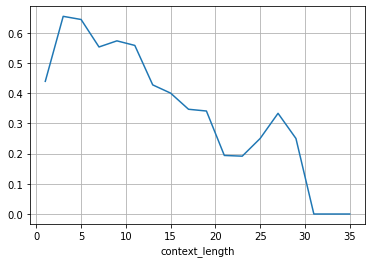

In [53]:
df.groupby('context_length')['entity_prec'].mean().plot()
plt.grid()

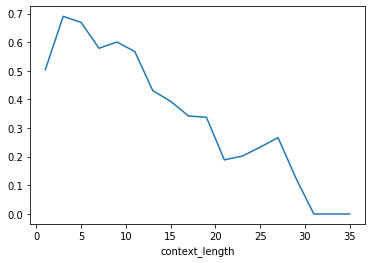

In [37]:
df.groupby('context_length')['entity_recall'].mean().plot()

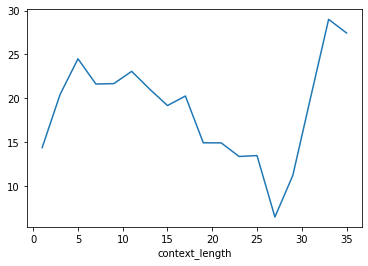

In [38]:
df.groupby('context_length')['bleu'].mean().plot()

Text(0.5, 1.0, 'Entity-F1 Score')

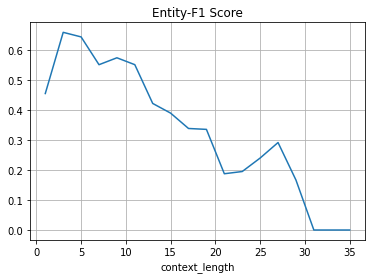

In [59]:
df.groupby('context_length')['entity_f1'].mean().plot()
plt.grid()
plt.title("Entity-F1 Score")

Text(0.5, 1.0, 'Number of samples in test set')

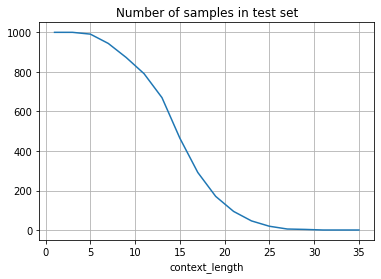

In [60]:
df.groupby('context_length')['file'].count().plot()
plt.grid()
plt.title("Number of samples in test set")

## [RESULT] Correctness of entities predicted

Our model is more accurate in the entities being mentioned also uses appropriate number of entities in the generated response. Our model uses almost the same or sometimes less numbers of entities in its responses compared to Marco as is more accurate on avg.

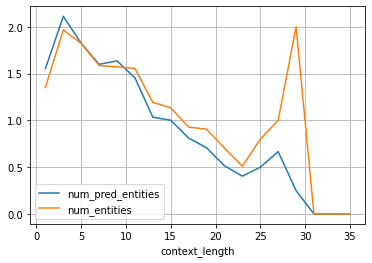

In [61]:
df.groupby('context_length')[['num_pred_entities', 'num_entities']].mean().plot()
plt.grid()

## [EXP] People vs. Number of Entities

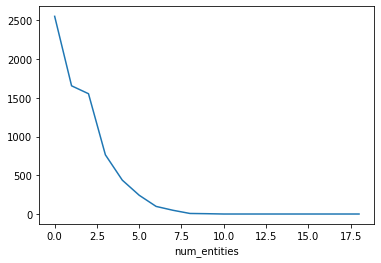

In [84]:
df.groupby('num_entities')['file'].count().plot()

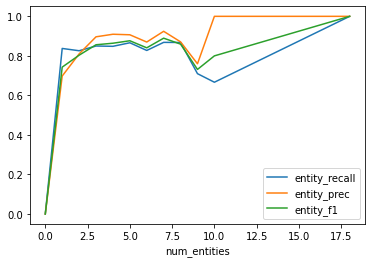

In [67]:
df.groupby('num_entities')[['entity_recall', 'entity_prec', 'entity_f1']].mean().plot()

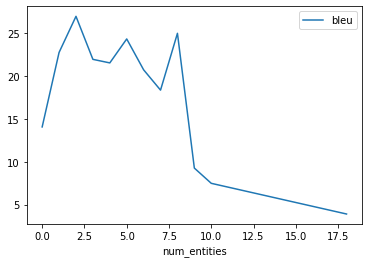

In [69]:
df.groupby('num_entities')[['bleu']].mean().plot()

(0.0, 15.0)

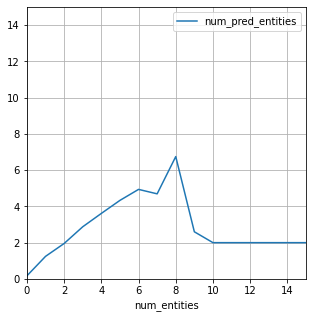

In [86]:
df.groupby('num_entities')[['num_pred_entities']].mean().plot(figsize=(5,5))
plt.grid()
plt.xlim((0, 15))
plt.ylim((0, 15))

## [DEFINE] Avg. Response Length

In [42]:
response_lengths = df.apply(lambda x: len(x["generated"].split()), 1)
response_lengths.mean()

17.494302767227346

# Process Dialog level Stats (Inform/Success)

In [43]:
df_temp = df.groupby('file')[['context_length']].max().reset_index()
df_temp['file'] = df_temp.apply(lambda r: r['file']+'.json', 1)
df_combo = pd.merge(df_temp, df_stats, how='inner', on='file')

In [44]:
df_combo.describe()

,context_length,match,success
count,1000.00000,1000.00000,1000.000000
mean,13.74400,0.87900,0.840000
std,4.74605,0.32629,0.366789
min,3.00000,0.00000,0.000000
25%,11.00000,1.00000,1.000000
50%,13.00000,1.00000,1.000000
75%,17.00000,1.00000,1.000000
max,35.00000,1.00000,1.000000


In [45]:
df_combo.head()

,file,context_length,match,success
0,MUL0003.json,15,1.0,0
1,MUL0004.json,15,1.0,1
2,MUL0011.json,25,1.0,1
3,MUL0014.json,15,1.0,1
4,MUL0018.json,15,1.0,1


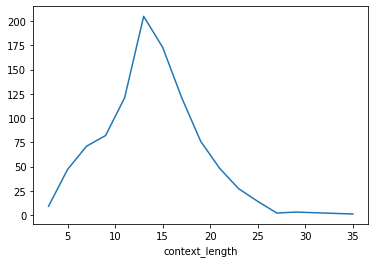

In [48]:
df_combo.groupby('context_length')['context_length'].count().plot()

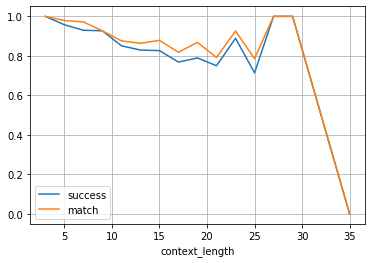

In [51]:
df_combo.groupby('context_length')[['success', 'match']].mean().plot()
plt.grid()

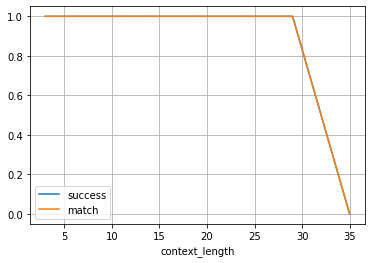

In [52]:
df_combo.groupby('context_length')[['success', 'match']].median().plot()
plt.grid()